This notebook takes a pre-trained CLIP model, fine-tune on tiny imagenet. Fine-tunes uses 5 hyper-parameters, and then evaluate model soup performance.

## Setup Environment

In [1]:
LOCAL = False

# if run locally:
if LOCAL:
    DATA_DIR = "../dataset"
    CODE_DIR = "../"
# on Colab
else:
    DATA_DIR = "/content"
    CODE_DIR = "./clip_TinyImageNet"



In [2]:
import os, sys
ROOT = os.path.abspath(CODE_DIR)
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

If you want to use Claude Code, uncomment the cell below.

In [3]:
# !npm install -g @anthropic-ai/claude-code

If use Colab, you need to save output results to google drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
storage_dir = "drive/MyDrive/Colab Notebooks/"

Mounted at /content/drive


We will work under the same dir as this notebook

To copy the code to fine-tune clip on tinyImageNet, run:

In [5]:
!git clone https://github.com/nbzy1995/clip_TinyImageNet.git

Cloning into 'clip_TinyImageNet'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 83 (delta 42), reused 79 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 2.48 MiB | 8.21 MiB/s, done.
Resolving deltas: 100% (42/42), done.


To download tiny imagenet dataset

In [6]:
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

Now we created a directory called "tiny-imagenet-200" containing the dataset.


We now copy pre-computed index for the train/ folder, 90% for training, 10% for validation. The val/ folder will be used as test set.

In [7]:
# if on Colab
!cp $CODE_DIR/dataset/tiny_imagenet_train_val_indices.npy /content/tiny_imagenet_train_val_indices.npy

Now we install the requirements for fine-tuning clip on tinyImageNet

In [8]:
!pip install --quiet --upgrade pip
!pip install -q -r clip_TinyImageNet/requirements.txt
print("✅ Core packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'clip' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'clip'. Discussion can be found at https://github.com/pypa/pip/issues/6334
✅ Core packages installed!


In [9]:
# Check GPU availability and system info
import torch
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("❌ No GPU available! Please enable GPU runtime in Colab.")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

🔍 System Information:
Python version: Python 3.12.11
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU device: Tesla T4
GPU memory: 15.8 GB
CUDA version: 12.6


## TinyImageNet - View

**First Time Setup:**
If the indices file doesn't exist, run the generation script ONCE:
```bash
cd dataset
python generate_train_val_indices.py
```

⚠️ **Do NOT run the generation script multiple times unless you want to change the split!**

In [10]:
# Check if persistent indices exist, generate if needed
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

sys.path.append(CODE_DIR)

INDICES_FILE = os.path.join(DATA_DIR, 'tiny_imagenet_train_val_indices.npy')

print("🔍 Checking for persistent indices...")

if os.path.exists(INDICES_FILE):
    print(f"✅ Found persistent indices: {INDICES_FILE}")
else:
    print(f"❌ Persistent indices not found: {INDICES_FILE}")




🔍 Checking for persistent indices...
✅ Found persistent indices: /content/tiny_imagenet_train_val_indices.npy


In [11]:
print("Creating datasets...")

from dataset.tiny_imagenet import TinyImageNet

# Use CLIP's expected preprocessing for proper model evaluation
import clip
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_, clip_preprocess = clip.load('ViT-B/32', device, jit=False)

data_tinyImageNet = TinyImageNet(
    train_preprocess=clip_preprocess,  # Use CLIP preprocessing for training
    eval_preprocess=clip_preprocess,   # Use CLIP preprocessing for evaluation
    location=DATA_DIR,
    batch_size=8,
    num_workers=2,
    distributed=False,
)

print(f"✅ Datasets created:")
print(f"   Train split: {len(data_tinyImageNet.train_sampler)} samples") # Train split (90% of original train data)
print(f"   Val split: {len(data_tinyImageNet.val_sampler)} samples")
print(f"   Test split: {len(data_tinyImageNet.test_loader.dataset)} samples")

Creating datasets...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 262MiB/s]


✅ Datasets created:
   Train split: 90000 samples
   Val split: 10000 samples
   Test split: 10000 samples


In [12]:
from itertools import islice

def show_split_samples(data, split_name, batch_index=0):
    """Show sample images with labels, indices, and paths"""

    if split_name == "train":
        loader = data.train_loader
    elif split_name == "validation":
        loader = data.val_loader
    elif split_name == "test":
        loader = data.test_loader

    # get one batch
    batch = next(islice(loader, batch_index, None))
    images = batch['images']
    labels = batch['labels']
    paths = batch['image_paths']
    print(f"fetching {len(labels)} samples")

    idx_to_class = data.idx_to_class

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        # Display image (denormalize from CLIP preprocessing)
        img = images[i]
        # CLIP normalization: mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        img = img * std + mean  # denormalize
        img = torch.clamp(img, 0, 1)  # clamp to [0,1]
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)
        axes[i].axis('off')

        # Get label info
        label_idx = int(labels[i])
        class_id = idx_to_class[label_idx]
        class_word = data.wordnet_map[class_id]

        # Show title with index and class
        axes[i].set_title(f"Label: {label_idx} | {class_id} | {class_word[:30]} \n Path: {os.path.basename(paths[i])}", fontsize=9)

    plt.tight_layout()
    plt.suptitle(f'{split_name.upper()} Split - Images with Labels', fontsize=14, y=1.02)
    plt.show()
    print()

Uncomment following cells to visualiza samples

In [13]:
# show_split_samples(data_tinyImageNet, "train",0)

In [14]:
# show_split_samples(data_tinyImageNet, "validation",6)

In [15]:
# show_split_samples(data_tinyImageNet, "test",0)

## Zero-shot classification

measure performance of CLIP zero-shot classifier on TinyImageNet dataset. use test split (val/ folder).

In [ ]:
!python $CODE_DIR/zeroshot.py --dataset TinyImageNet --batch-size 32 --data-location $DATA_DIR

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.24it/s]
[0% 0/313]	Acc: 53.12	Data (t) 0.818	Batch (t) 1.768
[6% 20/313]	Acc: 57.59	Data (t) 0.007	Batch (t) 0.097
[13% 40/313]	Acc: 59.83	Data (t) 0.007	Batch (t) 0.096
[19% 60/313]	Acc: 59.84	Data (t) 0.006	Batch (t) 0.095
[26% 80/313]	Acc: 60.53	Data (t) 0.010	Batch (t) 0.088
[32% 100/313]	Acc: 60.61	Data (t) 0.009	Batch (t) 0.087
[38% 120/313]	Acc: 61.13	Data (t) 0.002	Batch (t) 0.083
[45% 140/313]	Acc: 61.39	Data (t) 0.002	Batch (t) 0.081
[51% 160/313]	Acc: 61.55	Data (t) 0.

## Fine-tuning
We start with pretrained CLIP ViT-B/32, then fine-tune it on TinyImageNet. The training set is 90% of the train/, and 10% of them are used as validation set. We sweep for different hyperparameters to create 5 diverse models for model soups.

### Hyperparameter Configurations:
1. **Config 1**: lr=3e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
2. **Config 2**: lr=1e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False  
3. **Config 3**: lr=3e-6, wd=0.1, epochs=10, batch_size=256, timm_aug=False
4. **Config 4**: lr=2e-5, wd=1e-3, epochs=10, batch_size=256, timm_aug=True
5. **Config 5**: lr=1e-6, wd=1e-4, epochs=10, batch_size=256, timm_aug=False

In [ ]:
# Configuration 1: lr=3e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 3e-5 --wd 0.1 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config1"

# Backup model to Google Drive
!cp config1_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 1 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.22it/s]
Saving model to ./config1_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 1.442926	Data (t) 11.733	Batch (t) 15.286
Train Epoch: 0 [6% 20/352]	Loss: 1.261179	Data (t) 2.040	Batch (t) 2.307
Train Epoch: 0 [11% 40/352]	Loss: 0.963566	Data (t) 1.796	Batch (t) 2.055
Train Epoch: 0 [17% 60/352]	Loss: 1.013636	Data (t) 2.045	Batch (t) 2.076
Train Epoch: 0 [23% 80/352]	Loss: 0.916063	Data (t) 2.007	Batch (t) 2.073
Train Epoch: 0 [28% 100/352]	Loss: 0.836356	Data (t) 1.816	Batch (t) 2.080
T

In [ ]:
# Configuration 2: lr=1e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 1e-5 --wd 0.1 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config2"

# Backup model to Google Drive
!cp config2_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 2 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:11<00:00, 17.68it/s]
Saving model to ./config2_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 1.667826	Data (t) 14.185	Batch (t) 20.316
Train Epoch: 0 [6% 20/352]	Loss: 1.226475	Data (t) 1.959	Batch (t) 2.005
Train Epoch: 0 [11% 40/352]	Loss: 1.347273	Data (t) 2.024	Batch (t) 2.088
Train Epoch: 0 [17% 60/352]	Loss: 1.134597	Data (t) 2.014	Batch (t) 2.060
Train Epoch: 0 [23% 80/352]	Loss: 0.934149	Data (t) 2.039	Batch (t) 2.070
Train Epoch: 0 [28% 100/352]	Loss: 0.970417	Data (t) 2.030	Batch (t) 2.078
T

In [ ]:
# Configuration 3: lr=3e-6, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 3e-6 --wd 0.1 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config3"

# Backup model to Google Drive
!cp config3_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 3 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:11<00:00, 17.26it/s]
Saving model to ./config3_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 1.600170	Data (t) 10.423	Batch (t) 17.322
Train Epoch: 0 [6% 20/352]	Loss: 1.583610	Data (t) 2.006	Batch (t) 2.053
Train Epoch: 0 [11% 40/352]	Loss: 1.211902	Data (t) 2.009	Batch (t) 2.065
Train Epoch: 0 [17% 60/352]	Loss: 1.175887	Data (t) 2.009	Batch (t) 2.053
Train Epoch: 0 [23% 80/352]	Loss: 1.156675	Data (t) 2.027	Batch (t) 2.253
Train Epoch: 0 [28% 100/352]	Loss: 1.083810	Data (t) 2.030	Batch (t) 2.061
T

In [ ]:
# Configuration 4: lr=2e-5, wd=1e-3, epochs=10, batch_size=256, timm_aug=True
!python $CODE_DIR/finetune.py --lr 2e-5 --wd 1e-3 --epochs 10 --batch-size 256 --timm-aug --data-location $DATA_DIR --name "config4"

# Backup model to Google Drive
!cp config4_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 4 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:12<00:00, 16.02it/s]
Saving model to ./config4_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 3.308727	Data (t) 15.836	Batch (t) 23.652
Train Epoch: 0 [6% 20/352]	Loss: 2.737835	Data (t) 1.325	Batch (t) 1.400
Train Epoch: 0 [11% 40/352]	Loss: 2.778366	Data (t) 1.858	Batch (t) 2.029
Train Epoch: 0 [17% 60/352]	Loss: 2.296328	Data (t) 1.971	Batch (t) 2.070
Train Epoch: 0 [23% 80/352]	Loss: 2.271421	Data (t) 1.982	Batch (t) 2.036
Train Epoch: 0 [28% 100/352]	Loss: 2.170868	Data (t) 2.007	Batch (t) 2.054
T

In [ ]:
# Configuration 5: lr=1e-6, wd=1e-4, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 1e-6 --wd 1e-4 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config5"

# Backup model to Google Drive
!cp config5_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 5 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:12<00:00, 16.65it/s]
Saving model to ./config5_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 1.430876	Data (t) 13.988	Batch (t) 19.614
Train Epoch: 0 [6% 20/352]	Loss: 1.671773	Data (t) 2.032	Batch (t) 2.335
Train Epoch: 0 [11% 40/352]	Loss: 1.435908	Data (t) 2.023	Batch (t) 2.070
Train Epoch: 0 [17% 60/352]	Loss: 1.195043	Data (t) 2.033	Batch (t) 2.081
Train Epoch: 0 [23% 80/352]	Loss: 1.295531	Data (t) 2.033	Batch (t) 2.066
Train Epoch: 0 [28% 100/352]	Loss: 1.165548	Data (t) 1.821	Batch (t) 1.852
T

## Load Individual Models
Load the models after training all 5 configurations,

In [16]:
import torch
import clip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import tqdm
from utils import ModelWrapper,get_model_from_sd, eval_model_on_dataset

In [17]:
# Load all trained models (check both local and Drive backup)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_names = ['config1', 'config2', 'config3', 'config4', 'config5']
state_dicts = []
checkpoint_step = 3 # FROM 0 TO 10.

base_model, preprocess = clip.load('ViT-B/32', device, jit=False)
base_model = base_model.float() # Force the base model to stay in float32 to match saved weights

for name in model_names:
    # Load the final checkpoint (after 10 epochs)
    model_path = f'{name}_{checkpoint_step}.pt'
    drive_path = f'/content/drive/MyDrive/Colab Notebooks/{model_path}'

    # Try local first, then Drive backup
    if os.path.exists(model_path):
        print(f'Loading {model_path} (local)')
        state_dicts.append(torch.load(model_path, map_location=device))
    elif os.path.exists(drive_path):
        print(f'Loading {drive_path} (from Drive)')
        state_dicts.append(torch.load(drive_path, map_location=device))
    else:
        print(f'⚠️  Model {model_path} not found in local or Drive!')

print(f"✅ Loaded {len(state_dicts)} models successfully!")
print(f"Checkpoint at step {checkpoint_step}")

Loading /content/drive/MyDrive/Colab Notebooks/config1_3.pt (from Drive)
Loading /content/drive/MyDrive/Colab Notebooks/config2_3.pt (from Drive)
Loading /content/drive/MyDrive/Colab Notebooks/config3_3.pt (from Drive)
Loading /content/drive/MyDrive/Colab Notebooks/config4_3.pt (from Drive)
Loading /content/drive/MyDrive/Colab Notebooks/config5_3.pt (from Drive)
✅ Loaded 5 models successfully!


### Diagnostic: uncomment to use
- evaluate on samples of the train, val, test split
- evaluate one model

In [ ]:
# Choose one model idx
i = 0
print(f"\n🔍 Testing trained model {i} on training data sample...")

# Get number of classes from the dataset
num_classes = len(data_tinyImageNet.classnames)
debug_model = get_model_from_sd(state_dicts[i], base_model)


🔍 Testing trained model 0 on training data sample...


In [ ]:
from itertools import islice

def show_split_samples_model_pred(model, data, split_name, batch_index=0):
    """Show sample images with label and model prediction"""

    if split_name == "train":
        loader = data.train_loader
    elif split_name == "validation":
        loader = data.val_loader
    elif split_name == "test":
        loader = data.test_loader

    # get one batch
    batch = next(islice(loader, batch_index, None))
    images = batch['images']
    labels = batch['labels']
    print(f"fetching {len(labels)} samples")

    model.eval()
    with torch.no_grad():
        logits = model(images.to(device))
    pred = logits.argmax(dim=1, keepdim=True).cpu()
    print(f"pred: {pred.flatten()}")

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        # Display image (denormalize from CLIP preprocessing)
        img = images[i]
        # CLIP normalization: mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        img = img * std + mean  # denormalize
        img = torch.clamp(img, 0, 1)  # clamp to [0,1]
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)
        axes[i].axis('off')

        # Get label info
        pred_idx = int(pred[i])
        true_idx = int(labels[i])

        pred_class = data.idx_to_class[pred_idx]
        true_class = data.idx_to_class[true_idx]
        is_correct = (pred_idx == true_idx)

        color = 'green' if is_correct else 'red'
        axes[i].set_title(f"True: {data.wordnet_map[true_class][:20]}... \nPred: {data.wordnet_map[pred_class][:20]}...",
                         color=color, fontsize=10)

    plt.tight_layout()
    plt.suptitle(f'{split_name.upper()} Split - Images with Labels', fontsize=14, y=1.02)
    plt.show()
    print()

In [ ]:
# show_split_samples_model_pred(debug_model, data_tinyImageNet, "test",1)

### Evaluate individual models performance

In [18]:
# Use the test dataset from our data object

test_loader = data_tinyImageNet.test_loader
val_loader = data_tinyImageNet.val_loader

num_classes = len(data_tinyImageNet.classnames)
individual_results_test = []
individual_results_val = []

for i, state_dict in enumerate(state_dicts):
    print(f"\n📊 Evaluating Config {i+1}...")
    model = get_model_from_sd(state_dict, base_model)
    test_accuracy = eval_model_on_dataset(model, test_loader)
    val_accuracy = eval_model_on_dataset(model, val_loader)
    individual_results_test.append(test_accuracy)
    individual_results_val.append(val_accuracy)
    print(f"Config {i+1} Accuracy: {100*test_accuracy:.2f}%")

print(f"\n🎯 Individual Model Results:")
for i, acc in enumerate(individual_results_test):
    print(f"Config {i+1}: {100*acc:.2f}%")
print(f"Best Individual: {100*max(individual_results_test):.2f}%")


📊 Evaluating Config 1...
[0% 0/1250]	Acc: 62.50	Data (t) 0.278	Batch (t) 1.494
[2% 20/1250]	Acc: 77.98	Data (t) 0.003	Batch (t) 0.029
[3% 40/1250]	Acc: 74.39	Data (t) 0.001	Batch (t) 0.031
[5% 60/1250]	Acc: 73.98	Data (t) 0.001	Batch (t) 0.027
[6% 80/1250]	Acc: 74.23	Data (t) 0.001	Batch (t) 0.025
[8% 100/1250]	Acc: 74.75	Data (t) 0.001	Batch (t) 0.025
[10% 120/1250]	Acc: 74.79	Data (t) 0.006	Batch (t) 0.033
[11% 140/1250]	Acc: 75.35	Data (t) 0.001	Batch (t) 0.025
[13% 160/1250]	Acc: 75.93	Data (t) 0.001	Batch (t) 0.026
[14% 180/1250]	Acc: 76.59	Data (t) 0.001	Batch (t) 0.028
[16% 200/1250]	Acc: 76.62	Data (t) 0.001	Batch (t) 0.026
[18% 220/1250]	Acc: 76.36	Data (t) 0.001	Batch (t) 0.028
[19% 240/1250]	Acc: 76.50	Data (t) 0.001	Batch (t) 0.027
[21% 260/1250]	Acc: 76.53	Data (t) 0.001	Batch (t) 0.025
[22% 280/1250]	Acc: 76.65	Data (t) 0.001	Batch (t) 0.061
[24% 300/1250]	Acc: 76.70	Data (t) 0.003	Batch (t) 0.048
[26% 320/1250]	Acc: 76.79	Data (t) 0.026	Batch (t) 0.108
[27% 340/1250]	Ac

## Model Soup
Create and evaluate uniform and greedy model soups

In [20]:
def create_soup(state_dicts, weights=None):
    """Create a model soup by averaging state dicts with given weights"""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)

    # Start with the first model weighted
    soup_state_dict = {k: v.clone() * weights[0] for k, v in state_dicts[0].items()}

    # Add remaining models
    for i, state_dict in enumerate(state_dicts[1:], 1):
        for k, v in state_dict.items():
            soup_state_dict[k] += v.clone() * weights[i]

    return soup_state_dict


In [21]:
# Create and evaluate uniform soup (simple average)
print("🍲 Creating Uniform Soup...")
uniform_soup_state = create_soup(state_dicts)
uniform_soup_model = get_model_from_sd(uniform_soup_state, base_model)
uniform_accuracy = eval_model_on_dataset(uniform_soup_model, test_loader)

print(f"\n🍲 Uniform Soup Accuracy: {100*uniform_accuracy:.2f}%")
print(f"Improvement over best individual: {100*uniform_accuracy - 100*max(individual_results_test):.2f}%")


# Also backup final soup results to Drive
import pickle
results = {
    'individual_results': individual_results_test,
    'uniform_accuracy': uniform_accuracy,
    # 'greedy_accuracy': best_accuracy,
    # 'greedy_indices': greedy_indices,
    'model_configs': [
        'lr=3e-5, wd=0.1, timm_aug=False',
        'lr=1e-5, wd=0.1, timm_aug=False',
        'lr=3e-6, wd=0.1, timm_aug=False',
        'lr=2e-5, wd=1e-3, timm_aug=True',
        'lr=1e-6, wd=1e-4, timm_aug=False'
    ]
}

with open(f'/content/drive/MyDrive/Colab Notebooks/soup_results_{checkpoint_step}.pkl', 'wb') as f:
    pickle.dump(results, f)
print("💾 Soup results saved to Drive!")

# # Simple greedy soup implementation (add models if they improve performance)
# # NOTE: Use val split
# print(f"\n🧠 Creating Greedy Soup...")
# best_accuracy_val = 0
# best_state_dict = None
# greedy_indices = []

# # Start with the best individual model
# best_idx = np.argmax(individual_results_val)
# greedy_indices.append(best_idx)
# best_state_dict = state_dicts[best_idx]
# best_accuracy_val = individual_results_val[best_idx]

# print(f"Starting with Config {best_idx + 1} (val accuracy: {best_accuracy_val:.2f}%)")

# # Try adding each remaining model
# for i, state_dict in enumerate(state_dicts):
#     if i == best_idx:
#         continue

#     # Create soup with current best + this model
#     temp_soup = create_soup([best_state_dict, state_dict])
#     temp_model = get_model_from_sd(temp_soup, base_model)
#     temp_accuracy_val = eval_model_on_dataset(temp_model, val_loader)

#     print(f"Adding Config {i+1}:")
#     print(f"New val accu: {temp_accuracy_val:.2f}%")

#     if temp_accuracy_val > best_accuracy_val:
#         print(f"✅ Improved! Adding Config {i+1}")
#         greedy_indices.append(i)
#         best_state_dict = temp_soup
#         best_accuracy_val = temp_accuracy_val
#     else:
#         pass
#         # print(f"❌ No improvement, skipping Config {i+1}")

# # evaluae the greedy soup on test set


# print(f"\n🧠 Greedy Soup includes configs: {[i+1 for i in greedy_indices]}")



# print(f"🧠 Greedy Soup Accuracy: {best_accuracy_val:.2f}%")



# print(f"Improvement over best individual: {best_accuracy_val - max(individual_results):.2f}%")

🍲 Creating Uniform Soup...
[0% 0/1250]	Acc: 75.00	Data (t) 0.160	Batch (t) 0.201
[2% 20/1250]	Acc: 81.55	Data (t) 0.001	Batch (t) 0.027
[3% 40/1250]	Acc: 79.88	Data (t) 0.001	Batch (t) 0.028
[5% 60/1250]	Acc: 81.35	Data (t) 0.001	Batch (t) 0.027
[6% 80/1250]	Acc: 82.25	Data (t) 0.001	Batch (t) 0.028
[8% 100/1250]	Acc: 82.80	Data (t) 0.001	Batch (t) 0.029
[10% 120/1250]	Acc: 82.33	Data (t) 0.001	Batch (t) 0.027
[11% 140/1250]	Acc: 82.27	Data (t) 0.001	Batch (t) 0.028
[13% 160/1250]	Acc: 83.00	Data (t) 0.001	Batch (t) 0.027
[14% 180/1250]	Acc: 83.22	Data (t) 0.001	Batch (t) 0.038
[16% 200/1250]	Acc: 83.15	Data (t) 0.001	Batch (t) 0.028
[18% 220/1250]	Acc: 83.03	Data (t) 0.001	Batch (t) 0.024
[19% 240/1250]	Acc: 83.14	Data (t) 0.001	Batch (t) 0.042
[21% 260/1250]	Acc: 83.14	Data (t) 0.002	Batch (t) 0.033
[22% 280/1250]	Acc: 83.59	Data (t) 0.007	Batch (t) 0.041
[24% 300/1250]	Acc: 83.76	Data (t) 0.010	Batch (t) 0.047
[26% 320/1250]	Acc: 83.72	Data (t) 0.001	Batch (t) 0.029
[27% 340/1250]	A

📊 Summary Results:
         Method  Accuracy (%)
       Config 1         76.68
       Config 2         80.01
       Config 3         80.01
       Config 4         78.52
       Config 5         78.16
Best Individual         80.01
   Uniform Soup         83.44


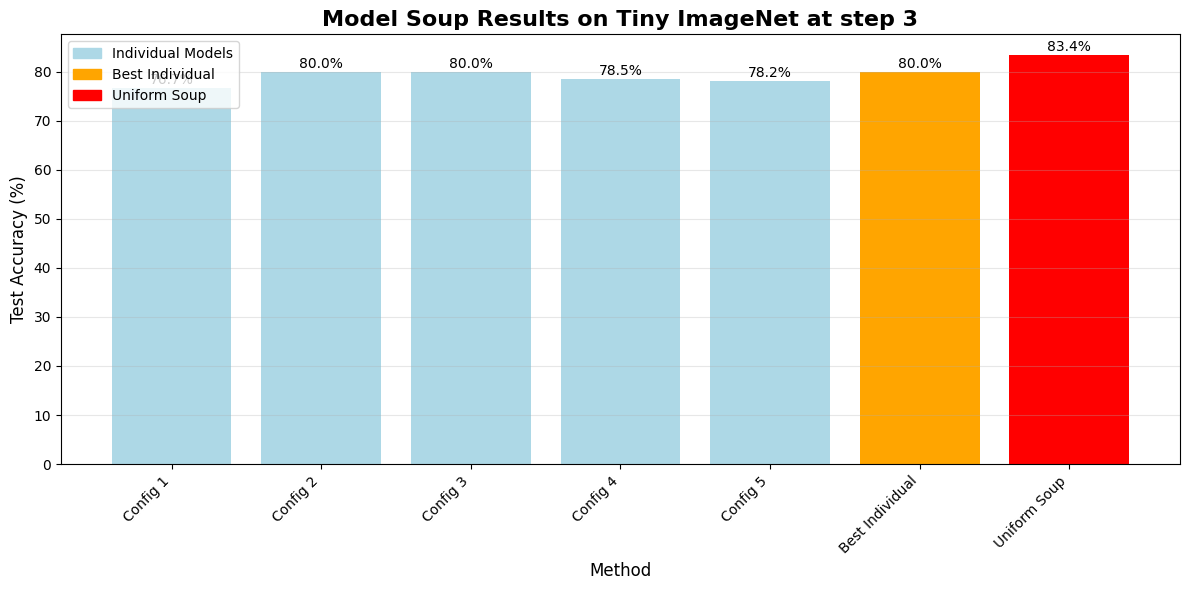


🎉 Final Results Summary:
Checkpoint 3
Zero-shot CLIP: ~61.39% (from earlier)
Best Individual Model: 0.80%
Uniform Soup: 0.83% (+0.03%)


In [24]:
# Create summary results
results_summary = {
    'Method': ['Config 1', 'Config 2', 'Config 3', 'Config 4', 'Config 5',
               'Best Individual', 'Uniform Soup'], # , 'Greedy Soup'
    'Accuracy (%)': np.array(individual_results_test + [max(individual_results_test), uniform_accuracy])*100 #, best_accuracy
}

# Create DataFrame for easy visualization
results_df = pd.DataFrame(results_summary)
print("📊 Summary Results:")
print(results_df.to_string(index=False))

# Plot results
plt.figure(figsize=(12, 6))
colors = ['lightblue'] * 5 + ['orange', 'red', 'green']
bars = plt.bar(results_df['Method'], results_df['Accuracy (%)'], color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.title(f'Model Soup Results on Tiny ImageNet at step {checkpoint_step}', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color='lightblue', label='Individual Models'),
                   plt.Rectangle((0,0),1,1, color='orange', label='Best Individual'),
                   plt.Rectangle((0,0),1,1, color='red', label='Uniform Soup')] # ,plt.Rectangle((0,0),1,1, color='green', label='Greedy Soup')

plt.legend(handles=legend_elements, loc='upper left')

plt.show()

# Print final summary
print(f"\n🎉 Final Results Summary:")
print(f"Checkpoint {checkpoint_step}")
print(f"Zero-shot CLIP: ~61.39% (from earlier)")
print(f"Best Individual Model: {max(individual_results_test):.2f}%")
print(f"Uniform Soup: {uniform_accuracy:.2f}% (+{uniform_accuracy - max(individual_results_test):.2f}%)")
# print(f"Greedy Soup: {best_accuracy:.2f}% (+{best_accuracy - max(individual_results):.2f}%)")